# Feature selection

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, VarianceThreshold, chi2, RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
import category_encoders as ce
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

n_cpu = multiprocessing.cpu_count()
n_cpu

16

In [2]:
def read_data(frac=0.02):
    dataframe = pd.read_csv('data/kickstarter.csv', parse_dates=['deadline', 'launched'])
    columns_to_drop_for_cleanup = ["category", "main_category", "country", "currency", "deadline", "launched", "name", "state"]
    
    # create new label by aggregating some of the possible choices
    dataframe = dataframe.assign(outcome=(dataframe['state'] == 'successful').astype(int))
    
    # cycling features handling and feature engineering on dates
    dataframe = dataframe[dataframe.launched != '1970-01-01 01:00:00']
    dataframe = dataframe.assign(
        launched_hour = dataframe.launched.dt.hour,
        launched_day = dataframe.launched.dt.day,
        launched_month = dataframe.launched.dt.month,
        launched_year = dataframe.launched.dt.year
    )
    dataframe['launched_hour_sin'] = np.sin(dataframe.launched_hour * (2. * np.pi/24))
    dataframe['launched_hour_cos'] = np.cos(dataframe.launched_hour * (2. * np.pi/24))
    dataframe['launched_month_sin'] = np.sin(dataframe.launched_month * (2. * np.pi/12))
    dataframe['launched_month_cos'] = np.cos(dataframe.launched_month * (2. * np.pi/12))
    dataframe["week_day"] = dataframe.launched.apply(lambda x: x.day_name())

    # categorical feature encoding
    label_encoding_columns = ["week_day"]
    label_encoder = ce.OrdinalEncoder(cols=label_encoding_columns)
    dataframe = label_encoder.fit_transform(dataframe)
    
    count_target_catboost_encoding_columns = ["category"]
    count_encoder = ce.CountEncoder()
    count_encoded = count_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns])
    dataframe = dataframe.join(count_encoded.add_suffix("_count"))
    target_encoder = ce.TargetEncoder(cols=count_target_catboost_encoding_columns)
    target_encoded = target_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns], dataframe["outcome"]) # normally fit on all and only do transform on the train set
    dataframe = dataframe.join(target_encoded.add_suffix("_target_encoded"))
    catboost_encoder = ce.CatBoostEncoder(cols=count_target_catboost_encoding_columns)
    catboost_encoded = catboost_encoder.fit_transform(dataframe[count_target_catboost_encoding_columns], dataframe["outcome"])
    dataframe = dataframe.join(catboost_encoded.add_suffix("_catboost_encoded"))
    
    one_hot_encoding_columns = ["main_category", "currency", "country"] 
    one_hot_encoder = ce.OneHotEncoder(cols=one_hot_encoding_columns)
    dataframe = one_hot_encoder.fit_transform(dataframe)
    
    # cleanup
    dataframe.drop(columns=columns_to_drop_for_cleanup, axis=1, inplace=True, errors="ignore")
    
    return dataframe.dropna().sample(frac=1).reset_index(drop=True).sample(frac=frac)

## Remove features with low variance

For boolean features, variance can be found with $Var[X] = p(1-p)$ since they are Bernoulli random variables.

By default, removes all zero variance features.

In [3]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
6687,1149088970,0,0,1,0,0,0,0,0,0,...,1,2012,-0.707107,7.071068e-01,5.000000e-01,0.866025,4,4451,0.631768,0.622284
76437,587298442,0,0,0,0,0,0,0,0,1,...,6,2017,-0.500000,8.660254e-01,1.224647e-16,-1.000000,5,7166,0.197321,0.198703
345595,1940160125,0,0,1,0,0,0,0,0,0,...,11,2010,0.866025,5.000000e-01,-5.000000e-01,0.866025,4,4451,0.631768,0.633981
28318,786088068,0,1,0,0,0,0,0,0,0,...,1,2015,-1.000000,-1.836970e-16,5.000000e-01,0.866025,1,16139,0.367061,0.367298
80365,1519521175,0,0,1,0,0,0,0,0,0,...,6,2016,0.965926,-2.588190e-01,1.224647e-16,-1.000000,5,15726,0.409004,0.408269


In [4]:
original_df.shape

(7497, 72)

In [5]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [6]:
threshold = 0.8 * (1 - 0.8)

selector = VarianceThreshold(threshold=threshold)
df = selector.fit_transform(original_df[feature_cols], original_df['outcome'])

In [7]:
selected_features = pd.DataFrame(selector.inverse_transform(df), index=original_df.index, columns=feature_cols)
selected_features.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
6687,1.149089e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2012.0,-0.707107,7.071068e-01,5.000000e-01,0.866025,4.0,4451.0,0.0,0.0
76437,5.872984e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,2017.0,-0.500000,8.660254e-01,1.224647e-16,-1.000000,5.0,7166.0,0.0,0.0
345595,1.940160e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,2010.0,0.866025,5.000000e-01,-5.000000e-01,0.866025,4.0,4451.0,0.0,0.0
28318,7.860881e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2015.0,-1.000000,-1.836970e-16,5.000000e-01,0.866025,1.0,16139.0,0.0,0.0
80365,1.519521e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,2016.0,0.965926,-2.588190e-01,1.224647e-16,-1.000000,5.0,15726.0,0.0,0.0


In [8]:
selected_columns = selected_features.columns[selected_features.var() != 0]
original_df[selected_columns].head()

,ID,currency_2,goal,pledged,backers,country_2,usd pledged,usd_pledged_real,usd_goal_real,launched_hour,launched_day,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count
6687,1149088970,1,1000.0,1353.33,22,1,1353.33,1353.33,1000.0,21,23,1,2012,-0.707107,7.071068e-01,5.000000e-01,0.866025,4,4451
76437,587298442,1,5000.0,7166.00,69,1,670.00,7166.00,5000.0,22,1,6,2017,-0.500000,8.660254e-01,1.224647e-16,-1.000000,5,7166
345595,1940160125,1,3000.0,3010.00,51,1,3010.00,3010.00,3000.0,4,22,11,2010,0.866025,5.000000e-01,-5.000000e-01,0.866025,4,4451
28318,786088068,1,1800.0,112.00,2,1,112.00,112.00,1800.0,18,27,1,2015,-1.000000,-1.836970e-16,5.000000e-01,0.866025,1,16139
80365,1519521175,1,3000.0,4611.00,65,1,3961.00,4611.00,3000.0,7,9,6,2016,0.965926,-2.588190e-01,1.224647e-16,-1.000000,5,15726


## Univariate Feature Selection

For each feature, measure how strongly the target depends on the feature using a statistical test like $X^2$ or ANOVA.

This is done one feature at a time.

In scikit learn, feature_selection.SelectKBest returns the K best features given some scoring function. We just need to decide the number of features we want to keep.

**SelectKBest should not be done on the validation and test set otherwise data leakage.**

* For regression: f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif

mutual_info_regression, mutual_info_classif, chi2 can handle sparse data without making it dense.

In [9]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
115532,369565148,0,0,0,0,1,0,0,0,0,...,9,2013,-0.866025,-0.500000,-1.000000e+00,-1.836970e-16,4,4198,0.336589,0.327809
257647,1566573513,0,0,1,0,0,0,0,0,0,...,7,2014,-0.965926,-0.258819,-5.000000e-01,-8.660254e-01,5,717,0.383543,0.385177
28430,809091113,0,0,0,0,0,0,0,0,0,...,6,2016,0.258819,0.965926,1.224647e-16,-1.000000e+00,7,6930,0.190043,0.190396
36087,1828379661,0,0,0,0,0,0,0,1,0,...,6,2017,-0.965926,-0.258819,1.224647e-16,-1.000000e+00,4,1864,0.542382,0.544998
27822,878114688,1,0,0,0,0,0,0,0,0,...,1,2016,-0.500000,0.866025,5.000000e-01,8.660254e-01,2,9169,0.243538,0.246074


In [10]:
original_df.shape

(7497, 72)

In [11]:
original_df.describe()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
count,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,...,7497.000000,7497.000000,7497.000000,7497.000000,7.497000e+03,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000
mean,1.076308e+09,0.104042,0.174203,0.136721,0.060024,0.080566,0.023209,0.094438,0.023876,0.065893,...,6.448046,2014.243564,-0.222152,0.210018,-1.238769e-02,-4.558626e-02,3.732693,7611.025077,0.353181,0.355152
std,6.282363e+08,0.305335,0.379309,0.343576,0.237547,0.272185,0.150578,0.292456,0.152674,0.248112,...,3.323857,1.938325,0.695297,0.650557,7.192977e-01,6.931900e-01,1.934435,5995.847301,0.141347,0.142590
min,3.981150e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2009.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,1.000000,49.000000,0.059574,0.016846
25%,5.201443e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,2013.000000,-0.866025,-0.258819,-8.660254e-01,-8.660254e-01,2.000000,2676.000000,0.255787,0.255332
50%,1.078430e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,2014.000000,-0.500000,0.258819,1.224647e-16,-1.836970e-16,4.000000,6345.000000,0.348816,0.350226
75%,1.619924e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2016.000000,0.500000,0.866025,8.660254e-01,5.000000e-01,5.000000,11493.000000,0.426869,0.431599
max,2.147365e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,2018.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,7.000000,22314.000000,0.664541,0.794221


In [12]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [13]:
selector = SelectKBest(f_classif, k=5)
df = selector.fit_transform(original_df[feature_cols], original_df['outcome'])

/home/gillouche/workspace/exploratory-data-analysis/venv-exploratory-data-analysis/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [43 53] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/gillouche/workspace/exploratory-data-analysis/venv-exploratory-data-analysis/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [14]:
selected_features = pd.DataFrame(selector.inverse_transform(df), index=original_df.index, columns=feature_cols)
selected_features.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
115532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336589,0.327809
257647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383543,0.385177
28430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.190043,0.190396
36087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542382,0.544998
27822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.243538,0.246074


In [15]:
selected_columns = selected_features.columns[selected_features.var() != 0]
original_df[selected_columns].head()

,backers,usd pledged,usd_pledged_real,category_target_encoded,category_catboost_encoded
115532,1114,51839.01,51839.01,0.336589,0.327809
257647,14,1245.00,1245.00,0.383543,0.385177
28430,11,585.00,585.00,0.190043,0.190396
36087,8,7.42,85.41,0.542382,0.544998
27822,0,0.00,0.00,0.243538,0.246074


## L1 Regularization (Lasso)

Penalizes the absolute magnitude of the coefficients. As the strength of regularization is increased, features which are less important for predicting the target are set to 0.

We can perform feature selection by adjusting the regularization parameter. We choose the parameter by finding the best performance on a hold-out set, or decide ahead of time how many features to keep.

C is the inverse of regularization strength, must be a positive float. smaller values specify strong regularization.

Not all solvers support L1 regularization.

* newton-cg: supports multi class problem, handles L2 and no penalty
* lbfgs: supports multi class problem, handles L2 and no penalty
* liblinear: good choice for small dataset, does not support multi class problem (only one versus rest), handles L1 penalty
* sag: good for large dataset, supports multi class problem, handles L2 and no penalty
* saga: good for large dataset, supports multi class problem, handles L1, L2, elasticnetand no penalty

In [16]:
original_df = read_data()
original_df.head()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
128816,1145355840,0,0,0,1,0,0,0,0,0,...,6,2017,-0.500000,0.866025,1.224647e-16,-1.000000,5,11493,0.286870,0.309576
1933,2003696916,0,0,0,0,1,0,0,0,0,...,7,2014,-0.500000,-0.866025,-5.000000e-01,-0.866025,5,22314,0.356816,0.362765
345972,1952889698,0,1,0,0,0,0,0,0,0,...,7,2010,-0.965926,-0.258819,-5.000000e-01,-0.866025,6,12357,0.540018,0.545159
295154,1163594746,0,0,1,0,0,0,0,0,0,...,7,2014,-0.500000,-0.866025,-5.000000e-01,-0.866025,4,15726,0.409004,0.423053
128178,1772404441,0,0,1,0,0,0,0,0,0,...,10,2014,-0.965926,-0.258819,-8.660254e-01,0.500000,6,717,0.383543,0.371652


In [17]:
original_df.describe()

,ID,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,...,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos,week_day,category_count,category_target_encoded,category_catboost_encoded
count,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,...,7497.000000,7497.000000,7497.000000,7497.000000,7.497000e+03,7.497000e+03,7497.000000,7497.000000,7497.000000,7497.000000
mean,1.064177e+09,0.106176,0.160864,0.131786,0.068027,0.081633,0.023743,0.092170,0.027611,0.059224,...,6.470321,2014.255169,-0.222414,0.216985,-1.267490e-02,-5.182192e-02,3.733227,7429.444311,0.352575,0.353938
std,6.134213e+08,0.308083,0.367430,0.338281,0.251809,0.273823,0.152257,0.289285,0.163867,0.236059,...,3.319312,1.938243,0.695823,0.647611,7.148977e-01,6.972863e-01,1.913639,5917.521381,0.141449,0.142456
min,3.780380e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2009.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,1.000000,27.000000,0.059574,0.042305
25%,5.410640e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,2013.000000,-0.866025,-0.258819,-8.660254e-01,-8.660254e-01,2.000000,2676.000000,0.255787,0.254726
50%,1.057731e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,2014.000000,-0.500000,0.258819,-2.449294e-16,-1.836970e-16,4.000000,6017.000000,0.347543,0.347927
75%,1.592884e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2016.000000,0.500000,0.866025,8.660254e-01,5.000000e-01,5.000000,11493.000000,0.417582,0.429465
max,2.147437e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,12.000000,2018.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,7.000000,22314.000000,0.771429,0.805302


In [18]:
original_df.shape

(7497, 72)

In [19]:
feature_cols = original_df.columns.drop('outcome')
feature_cols

Index(['ID', 'main_category_1', 'main_category_2', 'main_category_3',
       'main_category_4', 'main_category_5', 'main_category_6',
       'main_category_7', 'main_category_8', 'main_category_9',
       'main_category_10', 'main_category_11', 'main_category_12',
       'main_category_13', 'main_category_14', 'main_category_15',
       'currency_1', 'currency_2', 'currency_3', 'currency_4', 'currency_5',
       'currency_6', 'currency_7', 'currency_8', 'currency_9', 'currency_10',
       'currency_11', 'currency_12', 'currency_13', 'currency_14', 'goal',
       'pledged', 'backers', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'country_9', 'country_10', 'country_11', 'country_12', 'country_13',
       'country_14', 'country_15', 'country_16', 'country_17', 'country_18',
       'country_19', 'country_20', 'country_21', 'country_22', 'country_23',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched

In [20]:
X_train, X_test, y_train, y_test = train_test_split(original_df[feature_cols], original_df['outcome'], test_size=0.25, random_state=42)
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (5622, 71)
y train shape: (5622,)
X test shape: (1875, 71)
y test shape: (1875,)


In [21]:
standard_scaler = StandardScaler()

X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)

In [22]:
C = [10, 1, .1, .001, .0001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='saga', max_iter=10_000, n_jobs=n_cpu)
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')

C: 10
Coefficient of each feature: [[-4.04690667e-10 -1.02665196e-13 -1.24623005e-14  2.25646927e-13
  -1.77959730e-13 -1.69063022e-13 -4.55774408e-14 -4.78147406e-14
   9.95810083e-14 -1.61939747e-13  1.22782904e-13 -1.05387355e-14
  -6.29760350e-14 -3.65196194e-13  4.45729829e-14 -2.17156526e-14
  -2.30620972e-14 -2.94021844e-13 -8.24269339e-14 -6.12751069e-14
  -3.55622563e-15 -1.88892457e-13 -1.52654578e-14 -6.42175184e-15
  -3.30986581e-15 -4.83043690e-15  2.37017646e-15 -4.24492147e-15
   3.17737122e-16  0.00000000e+00 -1.57977722e-07  9.55555152e-08
   1.30431985e-09 -2.30620972e-14 -2.94021844e-13 -8.24269339e-14
  -6.12751069e-14 -3.55622563e-15 -2.78455890e-14 -3.98117599e-14
  -1.04699966e-16 -1.52654578e-14 -3.26373434e-14  0.00000000e+00
  -6.42175184e-15 -3.75788291e-14 -3.07916115e-14 -3.30986581e-15
  -4.83043690e-15 -1.57335619e-14  2.37017646e-15 -1.92743644e-15
  -4.24492147e-15  0.00000000e+00  3.17737122e-16  0.00000000e+00
   7.53061077e-08  9.24419748e-08 -1.4587

## Recursive Feature Elimination for feature selection

two important configuration options

* number of features to keep
* the algorithm used to help choose features

### For classification

In [23]:
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
print(X.shape, y.shape)

(1000, 10) (1000,)


In [24]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

In [25]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.890 (0.032)


In [26]:
pipeline.fit(X, y)
data = [[2.56999479,-0.13019997,3.16075093,-4.35936352,-1.61271951,-1.39352057,-2.48924933,-1.93094078,3.26130366,2.05692145]]
y_hat = pipeline.predict(data)
print('Predicted Class: %d' % (y_hat))

Predicted Class: 1


In [27]:
rfe.support_

array([False, False,  True,  True,  True, False,  True, False,  True,
       False])

In [28]:
rfe.ranking_

array([4, 5, 1, 1, 1, 6, 1, 3, 1, 2])

### For regression

In [29]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
print(X.shape, y.shape)

(1000, 10) (1000,)


In [30]:
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

In [31]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -27.077 (2.850)


In [32]:
pipeline.fit(X, y)
data = [[-2.02220122,0.31563495,0.82797464,-0.30620401,0.16003707,-1.44411381,0.87616892,-0.50446586,0.23009474,0.76201118]]
yhat = pipeline.predict(data)
print('Predicted: %.3f' % (yhat))

Predicted: -84.288


In [33]:
rfe.support_

array([False,  True, False, False,  True,  True,  True,  True, False,
       False])

In [34]:
rfe.ranking_

array([4, 1, 3, 6, 1, 1, 1, 1, 2, 5])

### RFE Hyperparameters

In [35]:
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y
 
def get_models():
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [36]:
X, y = get_dataset()
models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 0.720 (0.048)
>3 0.820 (0.034)
>4 0.872 (0.036)
>5 0.888 (0.029)
>6 0.886 (0.030)
>7 0.885 (0.026)
>8 0.885 (0.025)
>9 0.886 (0.024)


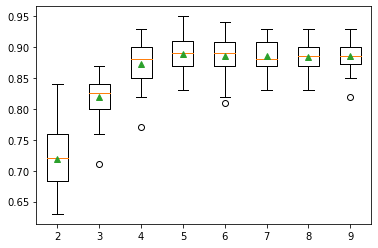

In [37]:
plt.boxplot(results, labels=names, showmeans=True);

## RFE internal algorithm

In [38]:
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
    return X, y
 
def get_models():
    models = dict()

    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['logi_reg'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['perceptron'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['dec_tree'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['rand_fo'] = Pipeline(steps=[('s',rfe),('m',model)])

    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['grad_boos'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=n_cpu)
    return scores


In [39]:
X, y = get_dataset()
models = get_models()

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


>logi_reg 0.890 (0.031)
>perceptron 0.845 (0.038)
>dec_tree 0.885 (0.031)
>rand_fo 0.856 (0.032)
>grad_boos 0.888 (0.031)


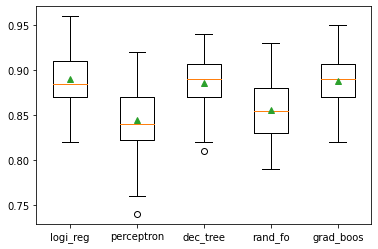

In [40]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()